# Send csv data to Monitor with Watson IoT Platform SDK & IBM Cloud Pak for Data

**Authors:** Christophe Lucas & James Petrie <br>
**Last Updated:** 12 May 2025

# Table of Contents
- [<b>Prerequisites</b>](#req)
- [<b>Install wiotp.sdk & import required libaries</b>](#wiotpsdk)        
- [<b>Read & visualise solar panel data</b>](#read)
    - [Read *solar-panel-readings.csv* into *solar_panel_readings* dataframe](#readcsv)
    - [Visualise solar panel data](#bokeh)
- [<b>Send Data to Monitor</b>](#send)
    - [**Option A**: Send data real-time](#optiona)
        - [Create XY-SolarPanel-A & XY-SolarPanel-A-001 in Monitor](#createdevicemonitor1)
        - [Add Metrics to XY-SolarPanel-A](#metrics1)        
        - [Update myConfig file & connect to XY-SolarPanel-A-001](#configa)
        - [Send data real time (at x frequency)](#senda)
    - [**Option B**: Send past & future data](#optionb)
        - [Update EVT_TIMESTAMP in *solar_panel_readings* dataframe](#evt)
        - [Visualize *solar_panel_readings* data with updated EVT_TIMESTAMP](#viewup)        
        - [Create XY-SolarPanel-B & XY-SolarPanel-B-001 in Monitor](#createdevicemonitor2)
        - [Add Metrics (including EVT_TIMESTAMP) to XY-SolarPanel-B](#metrics2)        
        - [Update myConfig file & connect to XY-SolarPanel-B-001](#configb)        
        - [Bulk send past & future data](#sendb)
- [<b>Play the 'Energy Loss' story end-to-end</b>](#play)
    - [Create Anomaly Function & Dashboard](#anomaly)
    - [Create Alerts & Service Request](#sr)


<a id='req'> </a>
# Prerequisites

Before you start with this Notebook, ensure you followed the steps in <a href="https://github.com/IBM/mas-drone-to-fix-watsonx/blob/main/energyloss-simulated/README.md#ready" target="_blank">Get ready </a> i.e. you have: 
- your MAS Monitor IoT Tool details (`"orgId"`, `"domain"`) & certificate (`iot-yourgeomas-xyz-com.pem`)
- the `solar-panel-readings.csv` & certificate (`iot-yourgeomas-xyz-com.pem`) files are under the Data Assets section of this CP4D Project.

<a id='wiotpsdk'> </a>
# Install wiotp.sdk & import required libaries

Install `wiotp.sdk` (see https://pypi.org/project/wiotp-sdk/)

In [ ]:
pip install wiotp.sdk

Install `bokeh`

In [ ]:
pip install bokeh

Import required libraries

In [2]:
import wiotp.sdk.device
import bokeh
import pandas as pd
import time
import argparse
from datetime import datetime

<a id='read'> </a>
# Read & visualise solar panel data

<a id='readcsv'> </a>
## Read *solar-panel-readings.csv* into *solar_panel_readings* dataframe

Run below cell and note that on top of `power`, `current`, `voltage_bus` & `voltage_shunt`, the csv also contains readings for `ghi_upper` & `ghi_lower` which correspond to the max and min Global Horizontal Irradiance (GHI) hitting the solar panel.

In [3]:
import itc_utils.flight_service as itcfs

readClient = itcfs.get_flight_client()

nb_data_request = {
    'data_name': """solar-panel-readings.csv""",
    'interaction_properties': {
        #'row_limit': 500,
        'infer_schema': 'true',
        'infer_as_varchar': 'false'
    }
}

flightInfo = itcfs.get_flight_info(readClient, nb_data_request=nb_data_request)

solar_panel_readings = itcfs.read_pandas_and_concat(readClient, flightInfo, timeout=240)
solar_panel_readings.info()
solar_panel_readings.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5720 entries, 0 to 5719
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   power          5720 non-null   float64
 1   current        5720 non-null   float64
 2   voltage_bus    5720 non-null   float64
 3   voltage_shunt  5720 non-null   float64
 4   ghi_upper      5720 non-null   int32  
 5   ghi_lower      5720 non-null   int32  
 6   EVT_TIMESTAMP  5720 non-null   object 
dtypes: float64(4), int32(2), object(1)
memory usage: 268.2+ KB


,power,current,voltage_bus,voltage_shunt,ghi_upper,ghi_lower,EVT_TIMESTAMP
0,1.3,0.0,0.1,1.6,6,0,2024-09-09-22.30.03.728000
1,1.7,0.0,0.0,1.4,6,0,2024-09-09-22.30.08.730000
2,1.2,0.0,0.0,1.6,6,0,2024-09-09-22.30.13.733000
3,1.0,0.3,0.1,1.4,6,0,2024-09-09-22.30.18.735000
4,1.0,0.1,0.0,1.6,6,0,2024-09-09-22.30.23.737000


<a id='bokeh'> </a>
## Visualise solar panel data

`EVT_TIMESTAMP` needs to be of `datetime` type for the Bokeh plot

In [4]:
import pandas as pd
solar_panel_readings['EVT_TIMESTAMP'] = pd.to_datetime(solar_panel_readings['EVT_TIMESTAMP'], format='%Y-%m-%d-%H.%M.%S.%f')
solar_panel_readings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5720 entries, 0 to 5719
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   power          5720 non-null   float64       
 1   current        5720 non-null   float64       
 2   voltage_bus    5720 non-null   float64       
 3   voltage_shunt  5720 non-null   float64       
 4   ghi_upper      5720 non-null   int32         
 5   ghi_lower      5720 non-null   int32         
 6   EVT_TIMESTAMP  5720 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int32(2)
memory usage: 268.2 KB


Below cell draws the Bokeh plot.<br> 
Run the cell as-is, zoom in & out within the plot, select (subset of) readings on the left menu.<br>
**Note** the regular `power` drops which correspond to the moments when we covered the solar panel.

In [5]:
import bokeh
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, DatetimeTickFormatter
from bokeh.models.widgets import CheckboxGroup
from bokeh.layouts import column
from bokeh.io import push_notebook

output_notebook()

# Prepare the data for Bokeh
source = ColumnDataSource(solar_panel_readings)

# Define colors for each reading
colors = {
    'power': 'green',
    'current': 'red',    
    'voltage_bus': 'orange',
    'voltage_shunt': 'blue',
    'ghi_upper': 'purple',
    'ghi_lower': 'brown'
}

# Create the figure
p = figure(x_axis_type="datetime", title="Time Series Data", plot_width=1000, plot_height=500)
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Values'

p.xaxis.formatter = DatetimeTickFormatter(
    seconds="%Y-%m-%d %H:%M:%S",
    minsec="%Y-%m-%d %H:%M:%S",
    minutes="%Y-%m-%d %H:%M:%S",
    hourmin="%Y-%m-%d %H:%M:%S",
    hours="%Y-%m-%d %H:%M:%S",
    days="%Y-%m-%d %H:%M:%S",
    months="%Y-%m-%d %H:%M:%S",
    years="%Y-%m-%d %H:%M:%S"
)

# Add lines for each column with distinct colors
lines = {}
for col in colors:
    line = p.line(x='EVT_TIMESTAMP', y=col, source=source, legend_label=col, line_width=2, color=colors[col])
    lines[col] = line

# Configure the hover tool
hover = HoverTool()
hover.tooltips = [("EVT_TIMESTAMP", "@EVT_TIMESTAMP{%F %T}"), ("Value", "$y")]
hover.formatters = {"@EVT_TIMESTAMP": "datetime"}
p.add_tools(hover)

# CheckboxGroup to toggle visibility of lines
checkbox_group = CheckboxGroup(labels=list(colors.keys()), active=list(range(len(colors))))

def update(attr, old, new):
    active_labels = [checkbox_group.labels[i] for i in checkbox_group.active]
    for col in lines:
        lines[col].visible = col in active_labels
    push_notebook()

# Customize the legend
p.legend.location = "top_left"
p.legend.click_policy = "hide"  # Allow the user to hide lines by clicking on the legend

# Show the plot
show(p, notebook_handle=True)  

Loading BokehJS ...

The Bokeh plot should look like this:
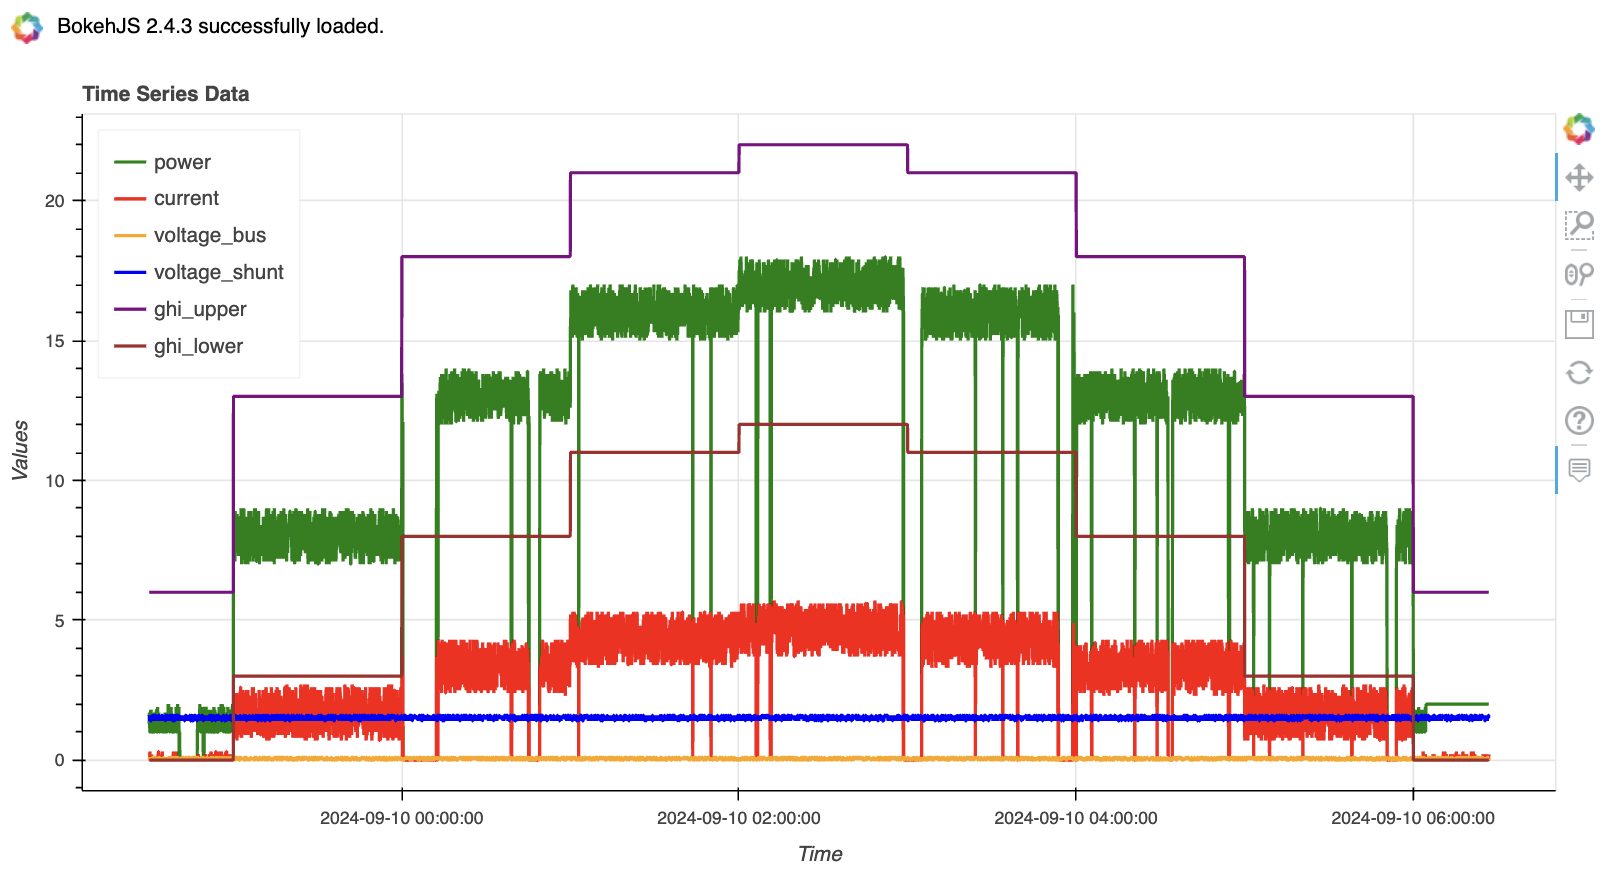

<a id='send'> </a>
# Send Data to Monitor

<a id='optiona'> </a>
## Option A: Send data real-time


<a id='createdevicemonitor1'> </a>
### Create XY-SolarPanel-A & XY-SolarPanel-A-001 in Monitor

Follow the arrows on the left side of below image:
1. Click Monitor left `Home` menu, click `Create a device type`, select `Basic template`, name your Device Type `XY-SolarPanel-A` (where `XY` are your initials e.g. `CL` in this recipe). Click `Create`. `XY-SolarPanel-A` should now appear on the `Setup` page.
2. From the `Setup` page, select `XY-SolarPanel-A` and click `Add device +` button. Name your Device `XY-SolarPanel-A-001`, click `Add`. **ATTENTION**: take note of the `Authentication token` on the last screen which will be `your_token_of_XY-SolarPanel-A-001`  to use as the `"token"` in the `myConfig` file (in 2 cells).

<a id='metrics1'> </a>
### Add Metrics to XY-SolarPanel-A

Follow the arrows on the right side of below image:
1. From the `Setup menu`, select `XY-SolarPanel-A`, go to `Identify` tab and click `Add metric+`.
2. First enter `power` row, write `event` in the `Event` colum. Repeat for `current`, `voltage_bus` & `voltage_shunt`, `ghi_upper` & `ghi_lower`. Click `Add`

Do NOT add any `EVT_TIMESTAMP` metric.

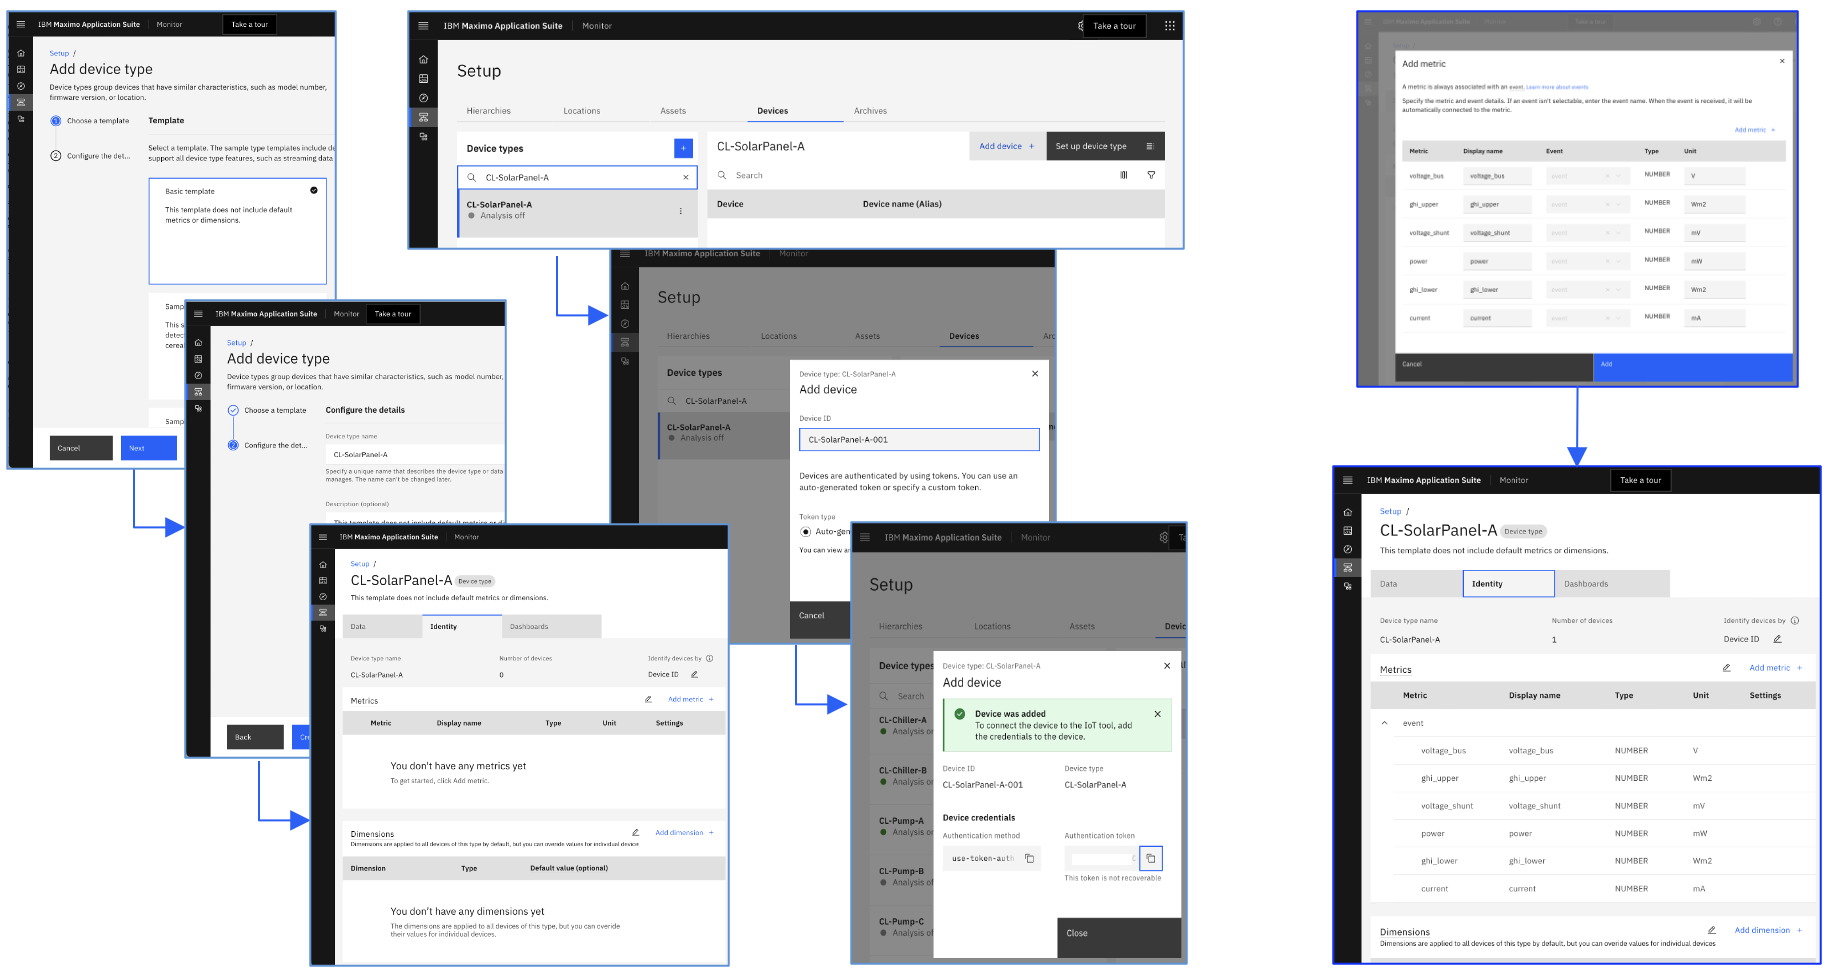

<a id='configa'> </a>
### Update myConfig file & connect to XY-SolarPanel-A-001

Update the following cell with your values of `"orgId"`, `"domain"`, `"caFile"` (`iot-yourgeomas-xyz-com.pem`) (see [<b>Prerequisites</b>](#req)) + `"your_token_of_XY-SolarPanel-A-001"` value in `"token"`.

In [ ]:
import wiotp.sdk.device

# Cloud Pak For Data way to access the iot-yourgeomas-xyz-com.pem file
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()
wslib.download_file("iot-yourgeomas-xyz-com.pem")


myConfig = {
    "identity": {
        "orgId": "your_orgId",
        "typeId": "XY-SolarPanel-A",
        "deviceId": "XY-SolarPanel-A-001"
    },
    "auth": {
        "token": "your_token_of_XY-SolarPanel-A-001"
    },
    "options": {
        "domain": "iot.yourgeomas.xyz.com",
        "http":{
            "verify": "True"
        },
        "mqtt":{
            "port":443,
            "caFile": "./iot-yourgeomas-xyz-com.pem"
        }
    }
}

print(myConfig)

Below is the command that connects you to the given Device on the IoT tool.<br>
It should output 1 `wiotp.sdk.device.client.DeviceClient  INFO    Connected successfully` message.
If you observe that you have regular connection followed by disconnection messages, use the next `deviceCli.disconnect()` cell and restart the kernel.

In [ ]:
deviceCli = wiotp.sdk.device.DeviceClient(config=myConfig)
deviceCli.connect()

Below command disconnects you from the given Device. <br>
Do NOT run first time as you want to stay connected. Just use when you need to connect to another Device and/or if conection is unstable, to restart.

In [ ]:
deviceCli = wiotp.sdk.device.DeviceClient(config=myConfig)
deviceCli.disconnect()

<a id='senda'> </a>
### Send data real time (at x frequency)

Change `EVT_TIMESTAMP` datetime back to string for WIoTP SDK call

In [ ]:
solar_panel_readings['EVT_TIMESTAMP'] = solar_panel_readings['EVT_TIMESTAMP'].dt.strftime('%Y-%m-%d %H:%M:%S')
solar_panel_readings.info()
solar_panel_readings.head(2)

**BELOW IS THE KEY CELL WHERE YOU SEND DATA (deviceCli.publishEvent)** <br>
Note that we do NOT use `EVT_TIMESTAMP` at all as the frequency at which data is sent is determined by the following variable.<br><br>
In this cell at the following line <br>
`parser.add_argument("-D", "--delay", required=False, type=float, default=0.1, help="number of seconds between msgs")` <br> 
the value set in `default=0.1` indicates the frequency at which the events are sent, i.e. `default=1` means 1 message every second, `default=0.1` means 10 messages every second, `default=10` means 1 message every 10 seconds.<br>
Run this cell as-is - initial default is 

| Running 5,720 reading at frequency (default =)  | Duration of 1 x 5,720 run |
| ----------- | ----------- |
| 0.01 = 100 / sec | 57 seconds. |
| 0.1 = 10 / sec | 9 minutes 32 seconds. |
| **1 = 1 / sec** |  **1 hour 35 minutes 20 seconds. DEMO Default** |
| 5 = 1 / 5 sec | 7 hours 43 minutes 20 seconds. |
| 30 = 1 / 30 sec | 47 hours 40 minutes. |
| 60 = 1 / min | 3 days 23 hours 20 minutes. |
| 600 = 1 / 10 min | 39 days 17 hours. |
| 1800 = 1 / 30 min | 3 months 27 days 4 hours. |
| 3600 = 1 / hour | 7 months, 24 days, and 8 hours. |

You should expect the following output i.e. the cell should keep running at the frequency you defined and 1 `SUCCESS` row appear each time 1 reading is sent. :

```python
{'power': 1.3, 'current': 0.0, 'voltage_bus': 0.1, 'voltage_shunt': 1.6, 'ghi_upper': 6, 'ghi_lower': 0}
======SUCCESS====== 2024-11-15 02:11:01.637376 ===Row: 1
 Success: True
{'power': 1.7, 'current': 0.0, 'voltage_bus': 0.0, 'voltage_shunt': 1.4, 'ghi_upper': 6, 'ghi_lower': 0}
======SUCCESS====== 2024-11-15 02:11:02.645049 ===Row: 2 Success: True

```

STOP sending data by just stopping this cell.



In [ ]:
import argparse
i = 0
for index, row in solar_panel_readings.iterrows():
    data = {'power': row['power'],
            'current': row['current'],
            'voltage_bus': row['voltage_bus'],
            'voltage_shunt': row['voltage_shunt'],            
            'ghi_upper': row['ghi_upper'],            
            'ghi_lower': row['ghi_lower']
            }
    print(data)

    parser = argparse.ArgumentParser()
    parser.add_argument("-E", "--event", required=False, default="event", help="type of event to send")
    parser.add_argument("-N", "--nummsgs", required=False, type=int, default=1, help="send this many messages before disconnecting")

    parser.add_argument("-D", "--delay", required=False, type=float, default=1, help="number of seconds between msgs")
    args, unknown = parser.parse_known_args()

    def myOnPublishCallback():
        print()
    i = i + 1
    success = deviceCli.publishEvent(args.event, "json", data, qos=0, onPublish=myOnPublishCallback)
    now = datetime.now()
    print("======SUCCESS======", now, "===Row:", i,"Success:", success)
    if not success:
        print("Not connected to WIoTP")

    time.sleep(args.delay)

deviceCli.disconnect()

<a id='optionb'> </a>
## Option B: Send past & future data

Rerun [Read *solar-panel-readings.csv* into *solar_panel_readings* dataframe](#readcsv) and make sure you have disconnected from `XY-SolarPanel-A-001` using `deviceCli.disconnect()` (see [Update myConfig file & connect to XY-SolarPanel-A-001](#configa)).

<a id='evt'> </a>
### Set EVT_TIMESTAMP in *solar_panel_readings* dataframe

In this key cell, choose the `start_date`, `frequency_type` & `frequency` at which you want to send the 5,720 solar panel readings.<br>
Refer to this table:

| Running 5,720 reading at frequency  | Duration of 1 x 5,720 run |
| ----------- | ----------- |
| 0.01 = 100 / sec | 57 seconds. |
| 0.1 = 10 / sec | 9 minutes 32 seconds. |
| 1 = 1 / sec |  1 hour 35 minutes 20 seconds. |
| 5 = 1 / 5 sec | 7 hours 43 minutes 20 seconds. |
| 30 = 1 / 30 sec | 47 hours 40 minutes. |
| 60 = 1 / min | 3 days 23 hours 20 minutes. |
| 600 = 1 / 10 min | 39 days 17 hours. |
| **1800 = 1 / 30 min** | **3 months 27 days 4 hours.** |
| 3600 = 1 / hour | 7 months, 24 days, and 8 hours. |

**Note** Taking a default of `1 reading every 30 min` and selecting a start_date in the recent past will ensure you send both past & future data.

In [6]:
#=== Choose your start_date, frequency_type & frequency ===#
start_date = pd.Timestamp('2024-10-30T22:30:03Z')
frequency_type = 'minute'  # Can be 'minute', 'hour', or 'day'
frequency = 30            # Frequency in integer
#=======================================================#
print('=== start_date (first reading) = ', start_date)
print('=== frequency_type = ', frequency_type)
print('=== frequency = ', frequency)
#=======================================================#

# Calculate EVT_TIMESTAMP based on start_date, frequency_type & frequency
if frequency_type == 'minute':
    solar_panel_readings['EVT_TIMESTAMP'] = [start_date + pd.Timedelta(minutes=i * frequency) for i in range(len(solar_panel_readings))]
elif frequency_type == 'hour':
    solar_panel_readings['EVT_TIMESTAMP'] = [start_date + pd.Timedelta(hours=i * frequency) for i in range(len(solar_panel_readings))]
elif frequency_type == 'day':
    solar_panel_readings['EVT_TIMESTAMP'] = [start_date + pd.Timedelta(days=i * frequency) for i in range(len(solar_panel_readings))]
else:
    raise ValueError("Invalid frequency_type. Choose from 'minute', 'hour', or 'day'.")

# Calculate end_date as the last EVT_TIMESTAMP
end_date = solar_panel_readings['EVT_TIMESTAMP'].iloc[-1] if not solar_panel_readings.empty else None
print('=== end_date (last reading) = ', end_date)

solar_panel_readings.info()
solar_panel_readings.tail()

=== start_date (first reading) =  2024-10-30 22:30:03+00:00
=== frequency_type =  minute
=== frequency =  30
=== end_date (last reading) =  2025-02-27 02:00:03+00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5720 entries, 0 to 5719
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   power          5720 non-null   float64            
 1   current        5720 non-null   float64            
 2   voltage_bus    5720 non-null   float64            
 3   voltage_shunt  5720 non-null   float64            
 4   ghi_upper      5720 non-null   int32              
 5   ghi_lower      5720 non-null   int32              
 6   EVT_TIMESTAMP  5720 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(4), int32(2)
memory usage: 268.2 KB


,power,current,voltage_bus,voltage_shunt,ghi_upper,ghi_lower,EVT_TIMESTAMP
5715,2.0,0.0,0.1,1.5,6,0,2025-02-27 00:00:03+00:00
5716,2.0,0.0,0.1,1.5,6,0,2025-02-27 00:30:03+00:00
5717,2.0,0.0,0.0,1.6,6,0,2025-02-27 01:00:03+00:00
5718,2.0,0.0,0.0,1.6,6,0,2025-02-27 01:30:03+00:00
5719,2.0,0.2,0.0,1.5,6,0,2025-02-27 02:00:03+00:00


<a id='viewup'> </a>
### Visualize *solar_panel_readings* data with update EVT_TIMESTAMP

In [7]:
import bokeh
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, DatetimeTickFormatter
from bokeh.models.widgets import CheckboxGroup
from bokeh.layouts import column
from bokeh.io import push_notebook

output_notebook()

# Prepare the data for Bokeh
source = ColumnDataSource(solar_panel_readings)

# Define colors for each reading
colors = {
    'power': 'green',
    'current': 'red',    
    'voltage_bus': 'orange',
    'voltage_shunt': 'blue',
    'ghi_upper': 'purple',
    'ghi_lower': 'brown'
}

# Create the figure
p = figure(x_axis_type="datetime", title="Time Series Data", plot_width=1000, plot_height=500)
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Values'

p.xaxis.formatter = DatetimeTickFormatter(
    seconds="%Y-%m-%d %H:%M:%S",
    minsec="%Y-%m-%d %H:%M:%S",
    minutes="%Y-%m-%d %H:%M:%S",
    hourmin="%Y-%m-%d %H:%M:%S",
    hours="%Y-%m-%d %H:%M:%S",
    days="%Y-%m-%d %H:%M:%S",
    months="%Y-%m-%d %H:%M:%S",
    years="%Y-%m-%d %H:%M:%S"
)

# Add lines for each column with distinct colors
lines = {}
for col in colors:
    line = p.line(x='EVT_TIMESTAMP', y=col, source=source, legend_label=col, line_width=2, color=colors[col])
    lines[col] = line

# Configure the hover tool
hover = HoverTool()
hover.tooltips = [("EVT_TIMESTAMP", "@EVT_TIMESTAMP{%F %T}"), ("Value", "$y")]
hover.formatters = {"@EVT_TIMESTAMP": "datetime"}
p.add_tools(hover)

# CheckboxGroup to toggle visibility of lines
checkbox_group = CheckboxGroup(labels=list(colors.keys()), active=list(range(len(colors))))

def update(attr, old, new):
    active_labels = [checkbox_group.labels[i] for i in checkbox_group.active]
    for col in lines:
        lines[col].visible = col in active_labels
    push_notebook()

# Customize the legend
p.legend.location = "top_left"
p.legend.click_policy = "hide"  # Allow the user to hide lines by clicking on the legend

# Show the plot
show(p, notebook_handle=True)  

Loading BokehJS ...

<a id='createdevicemonitor2'> </a>
### Create XY-SolarPanel-B & XY-SolarPanel-B-001 in Monitor

Follow the arrows on the left side of below image:
1. Click Monitor left `Home` menu, click `Create a device type`, select `Basic template`, name your Device Type `XY-SolarPanel-B` (where `XY` are your initials e.g. `CL` in this recipe). Click `Create`. `XY-SolarPanel-B` should now appear on the `Setup` page.
2. From the `Setup` page, select `XY-SolarPanel-B` and click `Add device +` button. Name your Device `XY-SolarPanel-B-001`, click `Add`. **ATTENTION**: take note of the `Authentication token` on the last screen which you will use as the `"token"` value in the `myConfig` file (next cell).

<a id='metrics2'> </a>
###  Add Metrics (including EVT_TIMESTAMP) to XY-SolarPanel-B        

Follow the arrows on the right side of below image:
1. From the `Setup menu`, select `XY-SolarPanel-B`, go to `Identify` tab and click `Add metric+`.
2. First enter `power` row, write `event` in the `Event` colum. Repeat for `current`, `voltage_bus` & `voltage_shunt`, `ghi_upper` & `ghi_lower`. 
3. Add a `EVT_TIMESTAMP` row (type `TIMESTAMP`). Click `Add`. Once the metrics are added, make sure to tick the `Use this as default timestamp` next to your `EVT_TIMESTAMP`.

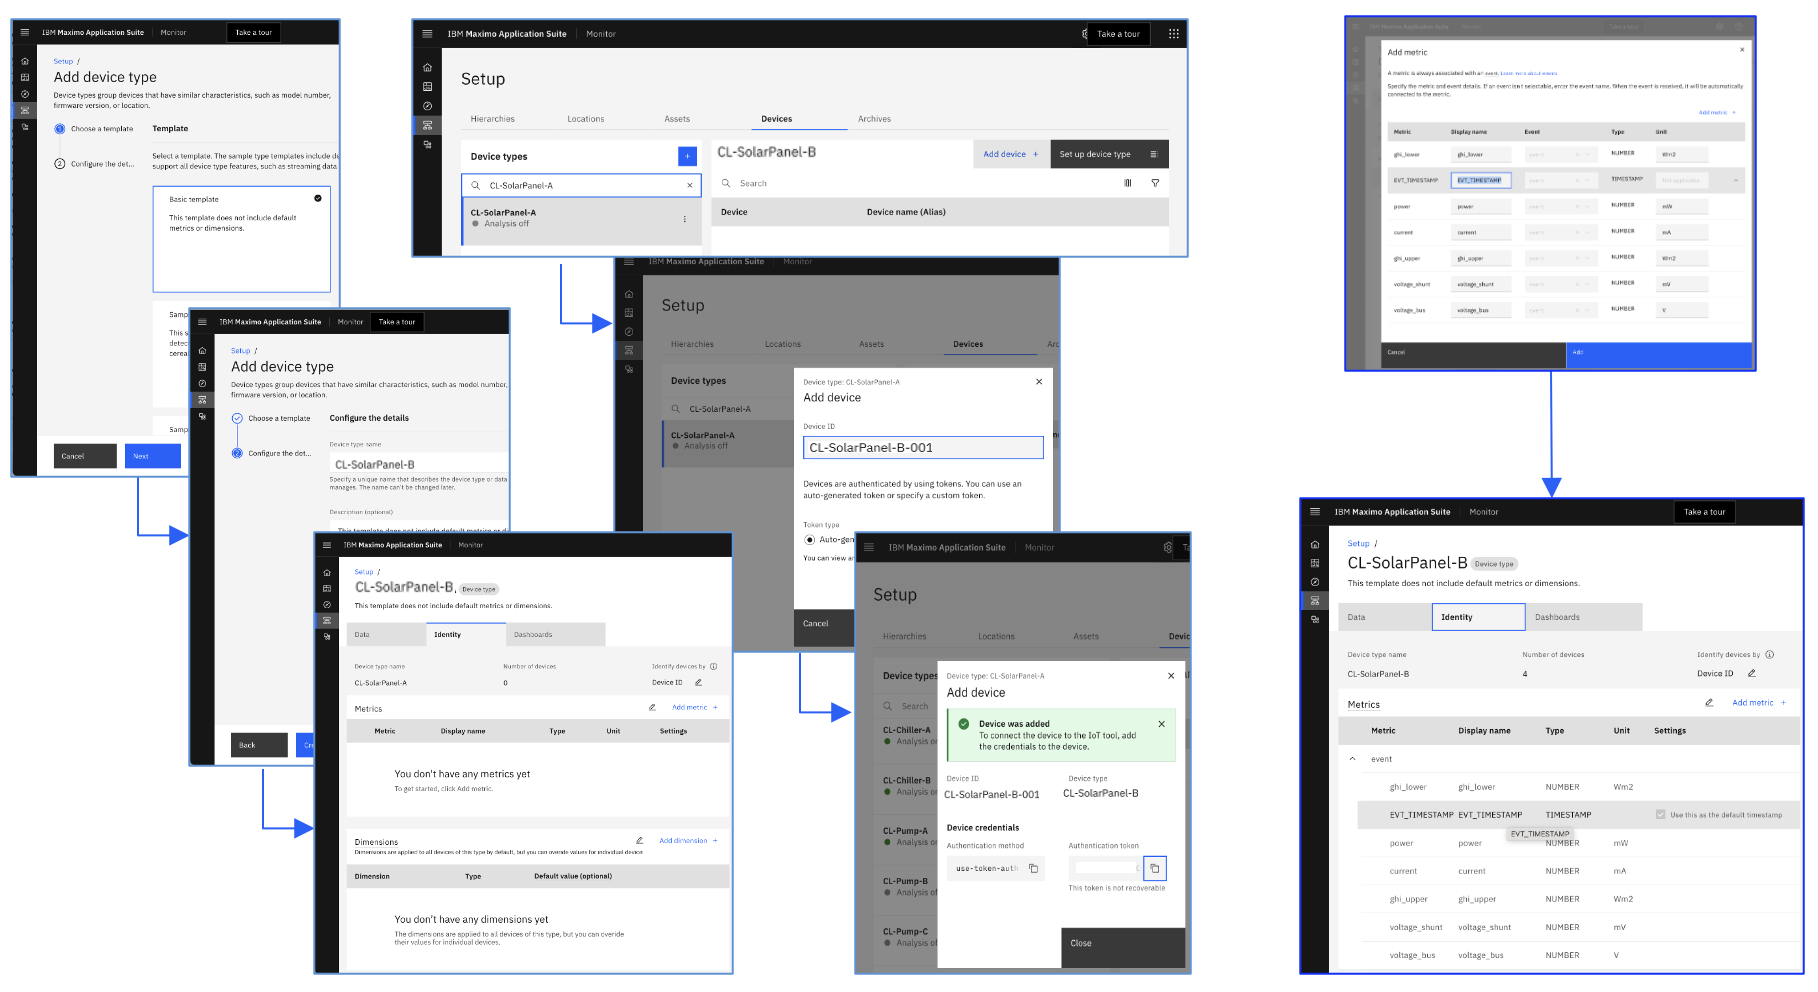

<a id='configb'> </a>
### Update myConfig file & connect to CL-SolarPanel-B-001

Update the following cell with your values of `"orgId"`, `"domain"`, `"caFile"` (`iot-yourgeomas-xyz-com.pem`) - see [<b>Prerequisites</b>](#req).

In [ ]:
import wiotp.sdk.device

# Cloud Pak For Data way to access the iot-wwgeomas-gtm-pat-com.pem
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()
wslib.download_file("iot-yourgeomas-xyz-com.pem")


myConfig = { 
    "identity": {
        "orgId": "your_orgId",
        "typeId": "XY-SolarPanel-B",
        "deviceId": "XY-SolarPanel-B-001"
    },
    "auth": {
        "token": "your_token_of_XY-SolarPanel-B-001"
    },
    "options": {
        "domain": "iot.yourgeomas.xyz.com",
        "http":{
            "verify": "True"
        },
        "mqtt":{
            "port":443,
            "caFile": "./iot-yourgeomas-xyz-com.pem"
        }
    }
}


print(myConfig)

Below is the command that connects you to the given Device on the IoT tool.<br>
It should output 1 `wiotp.sdk.device.client.DeviceClient  INFO    Connected successfully` message.
If you observe that you have regular connection followed by disconnection messages, use the next `deviceCli.disconnect()` cell and restart the kernel.

In [ ]:
deviceCli = wiotp.sdk.device.DeviceClient(config=myConfig)
deviceCli.connect()

Below command disconnects you from the given Device. <br>
Do NOT run first time as you want to stay connected. Just use when you need to connect to another Device and/or if conection is unstable, to restart.

In [ ]:
deviceCli = wiotp.sdk.device.DeviceClient(config=myConfig)
deviceCli.disconnect()

<a id='sendb'> </a>
## Bulk send past & future data

Change `EVT_TIMESTAMP` datetime back to string for WIoTP 

In [8]:
solar_panel_readings['EVT_TIMESTAMP'] = solar_panel_readings['EVT_TIMESTAMP'].dt.strftime('%Y-%m-%d %H:%M:%S')
solar_panel_readings.info()
solar_panel_readings.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5720 entries, 0 to 5719
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   power          5720 non-null   float64
 1   current        5720 non-null   float64
 2   voltage_bus    5720 non-null   float64
 3   voltage_shunt  5720 non-null   float64
 4   ghi_upper      5720 non-null   int32  
 5   ghi_lower      5720 non-null   int32  
 6   EVT_TIMESTAMP  5720 non-null   object 
dtypes: float64(4), int32(2), object(1)
memory usage: 268.2+ KB


,power,current,voltage_bus,voltage_shunt,ghi_upper,ghi_lower,EVT_TIMESTAMP
5715,2.0,0.0,0.1,1.5,6,0,2025-02-27 00:00:03
5716,2.0,0.0,0.1,1.5,6,0,2025-02-27 00:30:03
5717,2.0,0.0,0.0,1.6,6,0,2025-02-27 01:00:03
5718,2.0,0.0,0.0,1.6,6,0,2025-02-27 01:30:03
5719,2.0,0.2,0.0,1.5,6,0,2025-02-27 02:00:03


**BELOW IS THE KEY CELL WHERE YOU SEND DATA INCUDING `EVT_TIMESTAMP` (deviceCli.publishEvent)** <br>
Note that we DO use `EVT_TIMESTAMP` as the default timestamp metric for `XY-SolarPanel-B-001`.<br><br>

In this cell, we just want to bulk-send data, so we recommend using `default = 0.01` which means that sending the 5,720 rows should take less than 1 minute.


| Running 5,720 reading at frequency (default =)  | Duration of 1 x 5,720 run |
| ----------- | ----------- |
| **0.01 = 100 / sec** | **57 seconds.* |

You should expect the following output i.e. the cell should keep running until the 5,720 rows have been sent.

```python
{'power': 1.3, 'current': 0.0, 'voltage_bus': 0.1, 'voltage_shunt': 1.6, 'ghi_upper': 6, 'ghi_lower': 0}
======SUCCESS====== 2024-11-15 02:11:01.637376 ===Row: 1
 Success: True
{'power': 1.7, 'current': 0.0, 'voltage_bus': 0.0, 'voltage_shunt': 1.4, 'ghi_upper': 6, 'ghi_lower': 0}
======SUCCESS====== 2024-11-15 02:11:02.645049 ===Row: 2 Success: True

```

In [ ]:
index = 0
for index, row in solar_panel_readings.iterrows():
    data = {'power': row['power'],
            'current': row['current'],
            'voltage_shunt': row['voltage_shunt'],
            'voltage_bus': row['voltage_bus'],            
            'ghi_upper': row['ghi_upper'],            
            'ghi_lower': row['ghi_lower'],
            'EVT_TIMESTAMP': row['EVT_TIMESTAMP']
            }
    print(data)

    parser = argparse.ArgumentParser()
    parser.add_argument("-E", "--event", required=False, default="event", help="type of event to send")
    parser.add_argument("-N", "--nummsgs", required=False, type=int, default=1, help="send this many messages before disconnecting")

    parser.add_argument("-D", "--delay", required=False, type=float, default=0.01, help="number of seconds between msgs")
    args, unknown = parser.parse_known_args()

    def myOnPublishCallback():
        print()

    success = deviceCli.publishEvent(args.event, "json", data, qos=0, onPublish=myOnPublishCallback)
    now = datetime.now()
    print("======SUCCESS======", now, "===Row:", index,"Success:", success)
    if not success:
        print("Not connected to WIoTP")

    time.sleep(args.delay)

deviceCli.disconnect()

<a id='play'> </a>
# Play the 'Energy Loss' story end-to-end

<a id='anomaly'> </a>
## Create Anomaly Function & Dashboard

Create the `power_anomaly` data item:
1. From the `Monitor` left menu, `Devices` tab, select your Device Type e.g. `XY-SolarPanel-B` and click `Setup device type`.
2. In the `Data Items` menu, click `Create metric` under the `Batch data metric (calculated)` section. Select `KMeansAnomalyScore` function. Click `Next`. In the `input_item` field, select `power` (the power reading) and set `windowsize` to `12`. Click `Next`. On final screen, untick `Auto schedule` and set `Executing every` to `5 Minutes` and `Calculating the last` to `30 Days`. Name you data item `power_anomaly` and click `Create`. Wait 5 minutes for the `power_anomaly` to be calculated.

Create a Dashboard:
1. From the Monitor `Setup` menu, `Devices` tab, select your Device (NOT the Device Type) e.g. `XY-SolarPanel-B-001` and click the `+` buttom next to the `Metrics Dashboard` tab. Name it `Overview`.
2. Reproduce a Dashboard similar to the one in below picture i.e. (a) create a `Image` card and add a nice picture to it, (b) create a `Value/KPI` card and select the `current`, `voltage_bus`, `power` data items, call it `Last Readings`, (c) create a `Value/KPI` with , (d) importantly create a `Time Series` and display all readings on it, including the `power_anomaly` data item you just created.


<a id='sr'> </a>
## Create Alerts & Service Request

On the `Time Series` plot of the dashboard, select `power` and `power_anomaly` only and notice the spikes of the `power_anomaly` whenever there's a power drop. Observe the value of those spikes and  take note e.g. you will likely notice that the `power_anomaly` score spikes to values above `16` each time there is a drop.

Create the `alert_power_anomaly` data item and add it to the dashboard :
1. From the `Data Items` menu, click `Create metric` under the `Batch data metric (calculated)` section. Select `AlertHighValue` and click `Select`.
2. Click `Next`. Select `power_anomaly` in `input_item`, in `upper_threshold` enter the 'spike' value just mentionned e.g. `16`. Select `High` in `Severity` and `New` in `Status`. Click next and on last screen. Click `Create`.
3. Back to the dashboard, click `Edit dashboard` (top right) and add an `Alert table` as per image below.

Finally, you can now create a `Service Request` for a visual drone inspection from the Alert table.

**Well done - you made it !**

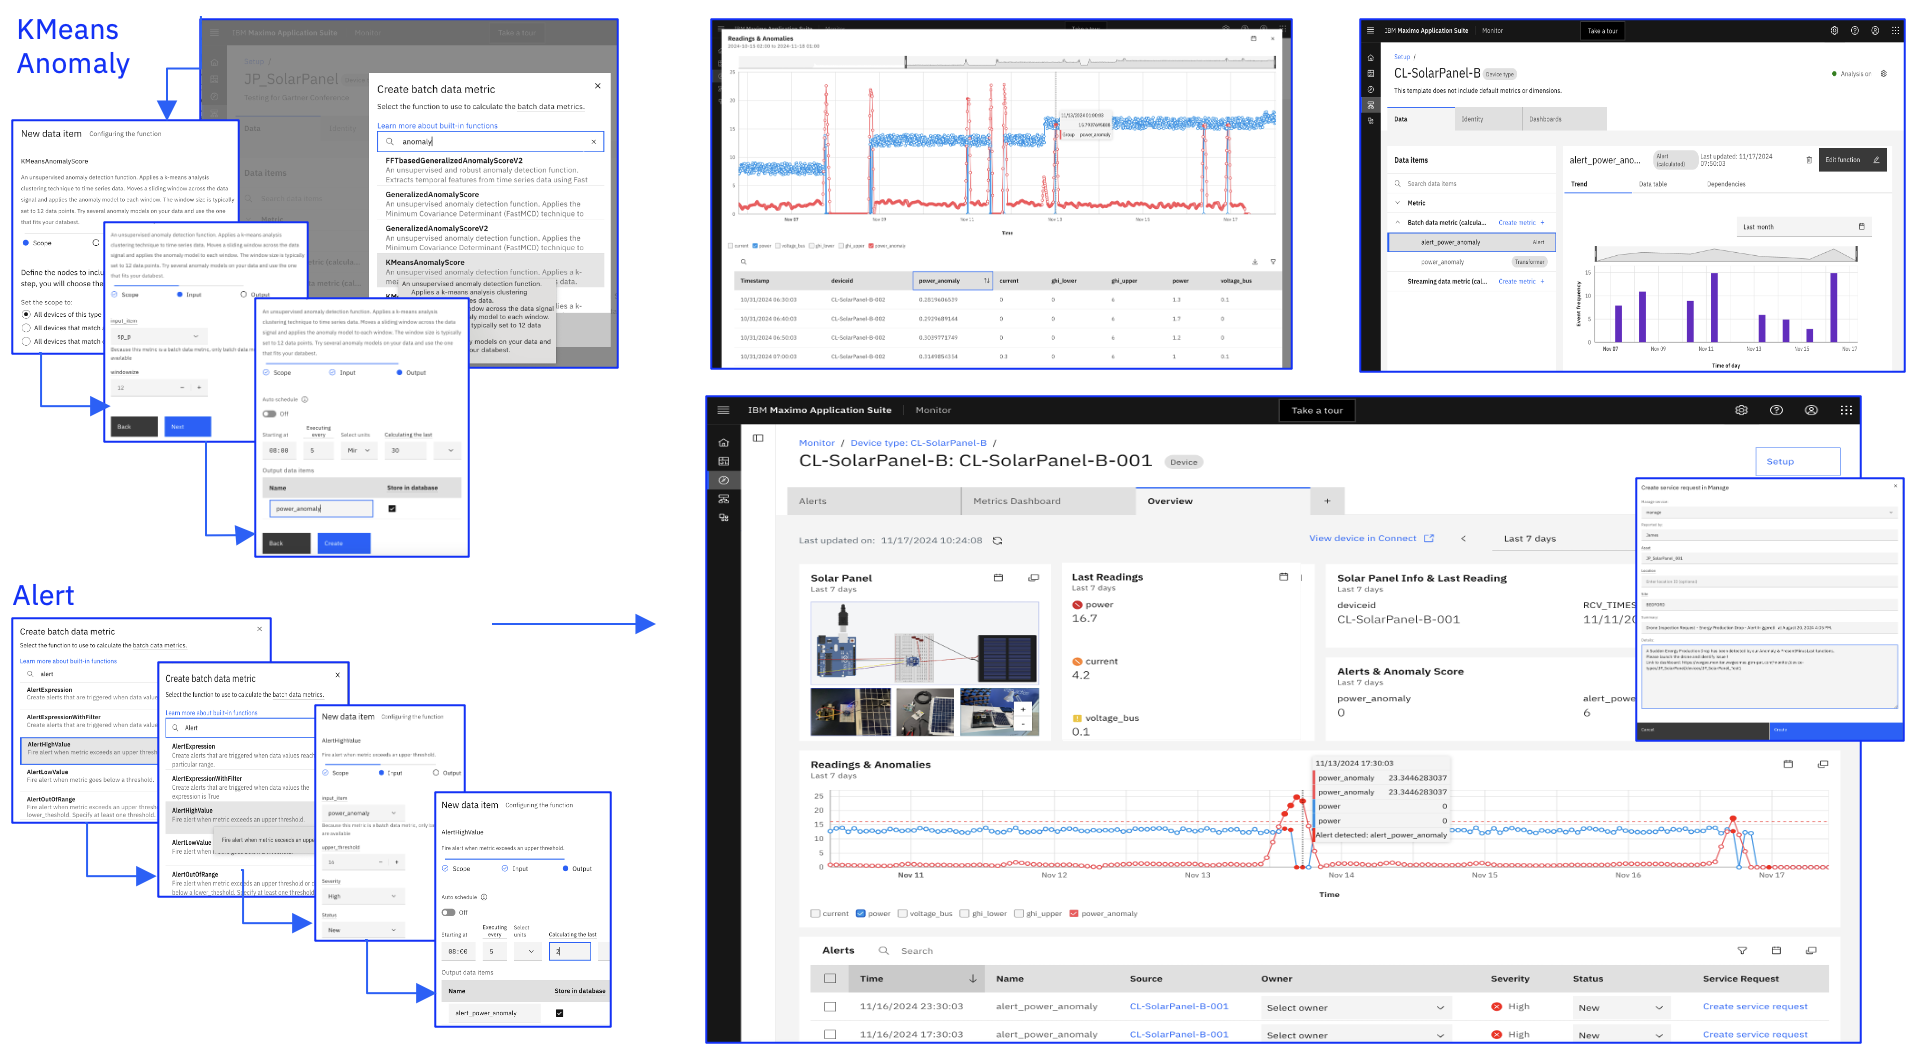